In [ ]:
pip install learn2learn

In [ ]:
cd drive/'My Drive'/new_dataset/data

/content/drive/My Drive/new_dataset/data


In [ ]:
import learn2learn as l2l
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import pickle
import sys
import argparse
import os
import json
import copy

from sklearn.metrics import r2_score

from matplotlib import pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
class DNN_Model(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DNN_Model, self).__init__()

        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        
        #x = torch.flatten(x, 1) 
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [ ]:
class MetaDataset(Dataset):

    def __init__(self, df):

        x = df
        x = x.drop('PM2.5', axis=1)
        x = x.values
        y = df['PM2.5'].values

        self.x = np.array(x)
        self.y = np.array(y)

        self.dim = self.x.shape[-1]

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        return torch.from_numpy(self.x[idx]), torch.tensor(self.y[idx]).view(1)
     
      
    def compute_standard_params(self):

        self.mean = np.mean(self.x.reshape(-1, self.dim), axis=0, keepdims=True)
        self.std = np.std(self.x.reshape(-1, self.dim), axis=0, keepdims=True)
        self.std[self.std==0.] = 1.

    def set_standard_params(self, mean, std):

        self.mean = mean
        self.std = std

    def get_standard_params(self):

        return self.mean, self.std

    def standarize(self):
        
        original_size = self.x.shape
        x_temp = self.x.reshape(-1, self.dim)
        self.x = ((x_temp - self.mean)/self.std).reshape(original_size)


In [ ]:
def scale_datasets(standarize = True, *datasets):

    train_dataset, validation_dataset, test_dataset = datasets

    if standarize:
        train_dataset.compute_standard_params()
        mean, std = train_dataset.get_standard_params()
        validation_dataset.set_standard_params(mean, std)
        test_dataset.set_standard_params(mean, std)

        train_dataset.standarize()
        validation_dataset.standarize()
        test_dataset.standarize()

In [ ]:
def create_dataset(idx, meta_train = False, meta_test = False):
    df = pd.read_csv(str(idx) + '/' + 'data1.csv')
    df = df[:int(0.8*len(df))]
    n = len(df)
    if meta_test:
        train_df = df[0:int(n*0.02)]
        val_df = df[int(n*0.02):int(n*0.04)]
        test_df = df[int(n*0.04):int(n*0.2)]

    elif meta_train:
        train_df = df
        train_dataset = MetaDataset(train_df)
        return train_dataset

    else:
        train_df = df[0:int(n*0.7)]
        val_df = df[int(n*0.7):int(n*0.9)]
        test_df = df[int(n*0.9):]
    
    train_dataset = MetaDataset(train_df)
    val_dataset = MetaDataset(val_df)
    test_dataset = MetaDataset(test_df)

    #scale_datasets(True, train_dataset, val_dataset, test_dataset)

    return train_dataset, val_dataset, test_dataset

In [ ]:
train_dataset, val_dataset, test_dataset = create_dataset(1)

In [ ]:
model = DNN_Model(input_dim = 4, hidden_dim = 64, output_dim =1).double()
loss_fn = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def train(model, loss_fn, optimizer, train_dataset, val_dataset, batch_size, epochs):

    train_dataloader = DataLoader(train_dataset, batch_size, shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size, shuffle=False)

    for t in range(epochs):

        #model.train()
        train_loss = 0
        train_size = len(train_dataloader)
        for batch, (X, y) in enumerate(train_dataloader):

            pred = model(X)
            loss = loss_fn(pred, y)
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        #validation
        #model.eval()
        val_loss = 0
        with torch.no_grad():

            val_size = len(val_dataloader)

            for X, y in val_dataloader:
                
                pred = model(X)
                loss = loss_fn(pred, y)
                val_loss += loss.item()

        train_loss /= train_size
        val_loss /= val_size
        
        print(f'Epoch: {t+1}/{epochs}.. Training loss: {train_loss:>8f}.. Validation Loss: {val_loss:>8f}')


In [ ]:
train(model, loss_fn, optimizer, train_dataset, val_dataset, 32, 20)

Epoch: 1/20.. Training loss: 43.054546.. Validation Loss: 23.795006
Epoch: 2/20.. Training loss: 23.816054.. Validation Loss: 18.528049
Epoch: 3/20.. Training loss: 26.223106.. Validation Loss: 20.413715
Epoch: 4/20.. Training loss: 20.472400.. Validation Loss: 19.885678
Epoch: 5/20.. Training loss: 21.674614.. Validation Loss: 19.730604
Epoch: 6/20.. Training loss: 19.528151.. Validation Loss: 20.187363
Epoch: 7/20.. Training loss: 19.467261.. Validation Loss: 20.347534
Epoch: 8/20.. Training loss: 19.347549.. Validation Loss: 20.516075
Epoch: 9/20.. Training loss: 19.178956.. Validation Loss: 20.618079
Epoch: 10/20.. Training loss: 18.679837.. Validation Loss: 20.840531
Epoch: 11/20.. Training loss: 18.666715.. Validation Loss: 21.037620
Epoch: 12/20.. Training loss: 18.596082.. Validation Loss: 21.186786
Epoch: 13/20.. Training loss: 18.345829.. Validation Loss: 21.444091
Epoch: 14/20.. Training loss: 18.384458.. Validation Loss: 21.557838
Epoch: 15/20.. Training loss: 18.190935.. V

In [ ]:
def test(test_dataset, model, batch_size):

    test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)
    size = len(test_dataloader)
    cal = []
    ref = []
    model.eval()
    test_loss = 0
    with torch.no_grad():

        for X, y in test_dataloader:

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            cal.extend(pred.detach().numpy())
            ref.extend(y.detach().numpy())

    test_loss /= size
    print(f"Avg loss: {test_loss:>8f} \n")
    plt.plot(ref)
    plt.plot(cal)
    plt.title('comparison')
    plt.ylabel('pm2.5')
    plt.xlabel('time')
    plt.legend(['reference', 'calibrated'], loc='upper left')
    plt.show()

Avg loss: 12.936881 



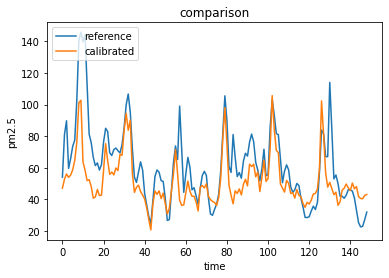

In [ ]:
test(test_dataset, model, 32)

In [ ]:
model = DNN_Model(input_dim = 4, hidden_dim = 128, output_dim =1).double()
model.to(device)
loss_fn = nn.L1Loss()
maml = l2l.algorithms.MAML(model, lr=0.001, first_order=False)
maml.to(device)
opt = optim.Adam(maml.parameters(), lr=0.0001)

In [ ]:
def meta_train(model, loss_fn, optimizer, adapt_steps, batch_size, epochs):

    for t in range(epochs):
        opt.zero_grad()
        error_spt = 0.0
        error_qry = 0.0       
        for i in range(batch_size):
            task = np.random.randint(0,10)
            learner = model.clone()
            train_dataset = create_dataset(task+6, meta_train = True) 
            train_dataloader = DataLoader(train_dataset,len(train_dataset), shuffle=True)
            #val_dataloader = DataLoader(val_dataset, 256, shuffle=True)

            #x_qry, y_qry = next(iter(val_dataloader))
            #x_spt, y_spt = next(iter(train_dataloader))

            x, y = next(iter(train_dataloader))
            d = random.randint(0, len(train_dataset)-450)
            
            x_spt, x_qry = x[d:d+50], x[d+50:d+450]
            y_spt, y_qry = y[d:d+50], y[d+50:d+450]
            x_qry, y_qry = x_qry.to(device), y_qry.to(device)
            x_spt, y_spt = x_spt.to(device), y_spt.to(device)

            for j in range(adapt_steps):

                pred = learner(x_spt)
                error = loss_fn(pred, y_spt)
                learner.adapt(error)

            pred_qry = learner(x_qry)
            pred_spt = learner(x_spt)
            loss_qry = loss_fn(pred_qry, y_qry)
            loss_spt = loss_fn(pred_spt, y_spt)
            error_qry += loss_qry
            error_spt += loss_spt
                
        # Meta-update the model parameters

        error_qry /= batch_size
        error_spt /= batch_size
        error_qry.backward()  
        opt.step()

        print(f'Epoch: {t+1}/{epochs}.. Query loss: {error_qry:>8f}.. Support Loss: {error_spt:>8f}')

In [ ]:
meta_train(maml, loss_fn, opt, 5, 32, 20000)

In [ ]:
#torch.save(maml, 'maml.pth')
model1 = DNN_Model(input_dim = 4, hidden_dim = 128, output_dim =1).double()
model1 = torch.load('maml_sq3128.pth', map_location='cpu')
learner = model1.clone()
loss_fn = nn.L1Loss()

In [ ]:
def target_train(train_dataset, val_dataset, batch_size, epochs):

    train_dataloader = DataLoader(train_dataset, batch_size, shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size, shuffle=False)
    t_loss = []
    v_loss = []
    #learner = model.clone()
    #learner.to(device)
    for t in range(epochs):

        #model.train()
        train_loss = 0
        train_size = len(train_dataloader)
        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            pred = learner(X)
            loss = loss_fn(pred, y)
            learner.adapt(loss)
            train_loss += loss.item()
        
        #validation
        #model.eval()
        val_loss = 0
        with torch.no_grad():

            val_size = len(val_dataloader)

            for X, y in val_dataloader:
                X, y = X.to(device), y.to(device)
                pred = learner(X)
                loss = loss_fn(pred, y)
                val_loss += loss.item()

        train_loss /= train_size
        val_loss /= val_size
        t_loss.append(train_loss)
        v_loss.append(val_loss)
        print(f'Epoch: {t+1}/{epochs}.. Training loss: {train_loss:>8f}.. Validation Loss: {val_loss:>8f}')

    plt.plot(t_loss)
    plt.plot(v_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'], loc='upper left')
    plt.show()

In [ ]:
train_dataset, val_dataset, test_dataset = create_dataset(5, meta_test = True)

Epoch: 1/10.. Training loss: 49.995164.. Validation Loss: 16.021610
Epoch: 2/10.. Training loss: 22.402618.. Validation Loss: 9.079943
Epoch: 3/10.. Training loss: 15.060723.. Validation Loss: 18.343551
Epoch: 4/10.. Training loss: 14.542879.. Validation Loss: 8.039889
Epoch: 5/10.. Training loss: 23.329454.. Validation Loss: 16.763965
Epoch: 6/10.. Training loss: 13.675417.. Validation Loss: 7.707440
Epoch: 7/10.. Training loss: 22.182326.. Validation Loss: 16.537631
Epoch: 8/10.. Training loss: 17.650410.. Validation Loss: 7.696178
Epoch: 9/10.. Training loss: 22.085245.. Validation Loss: 16.588354
Epoch: 10/10.. Training loss: 17.288072.. Validation Loss: 7.670239


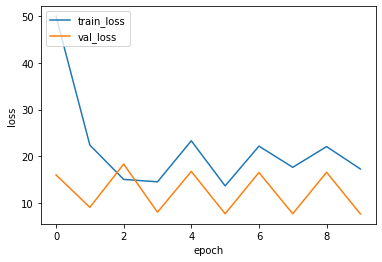

In [ ]:
target_train(train_dataset, val_dataset, 16, 10)

In [ ]:
def target_test(test_dataset, batch_size):

    ref = []
    cal = []
    raw = []
    test_dataloader = DataLoader(test_dataset, len(test_dataset), shuffle=False)
    size = len(test_dataloader)
    #model.eval()
    #test_loss = 0
    with torch.no_grad():
        X, y = next(iter(test_dataloader))
        X, y = X.to(device), y.to(device)
        pred = learner(X)
        test_loss = loss_fn(pred, y).item()
        ref.extend(y.cpu().detach().numpy())
        cal.extend(pred.cpu().detach().numpy())
        raw.extend(X[:,0].cpu().detach().numpy())
        #for X, y in test_dataloader:

            #pred = learner(X)
            #test_loss += loss_fn(pred, y).item()
            #ref.extend(y.detach().numpy())
            #cal.extend(pred.detach().numpy())

    #test_loss /= size
    print(f"Test loss: {test_loss:>8f} \n")
    print(f"R2 score: {r2_score(ref, cal):>8f} \n")
    plt.figure(figsize=(20, 5))
    plt.plot(ref)
    plt.plot(cal)
    plt.plot(raw)
    plt.title('comparison')
    plt.ylabel('pm2.5')
    plt.xlabel('time')
    plt.legend(['reference', 'calibrated', 'raw'], loc='upper left')
    plt.show()  

Test loss: 9.938944 

R2 score: 0.778509 



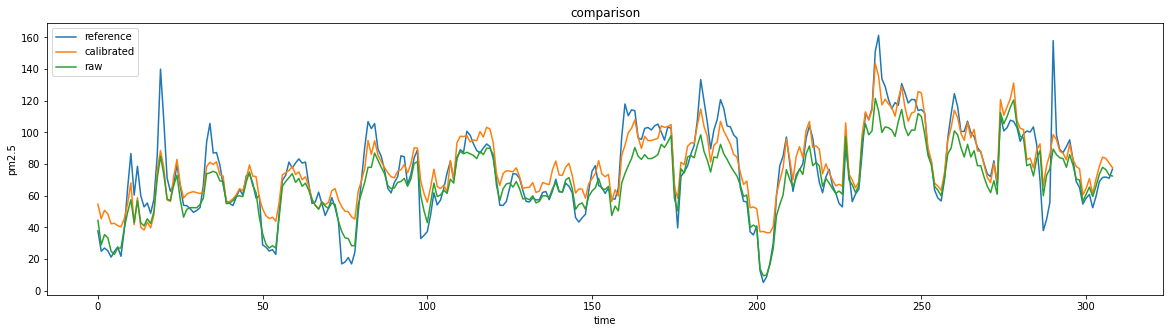

In [ ]:
target_test(test_dataset, 32)